In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras.layers import Dense, Conv1D, Reshape, Flatten, Lambda
from keras.optimizers import Adam
from keras import backend as K


def add_decorate(x):
    """
    axis = -1 --> last dimension in an array
    """
    m = K.mean(x, axis=-1, keepdims=True)
    d = K.square(x - m)
    return K.concatenate([x, d], axis=-1)


def add_decorate_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2
    shape[1] *= 2
    return tuple(shape)

# model.add(Lambda(antirectifier, output_shape=antirectifier_output_shape))


lr = 2e-4  # 0.0002
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999)


def model_compile(model):
    return model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


class GAN:
    def __init__(self, ni_D, nh_D, nh_G):
        self.ni_D = ni_D
        self.nh_D = nh_D
        self.nh_G = nh_G

        self.D = self.gen_D()
        self.G = self.gen_G()
        self.GD = self.make_GD()

    def gen_D(self):
        ni_D = self.ni_D
        nh_D = self.nh_D
        D = models.Sequential()
        D.add(Lambda(add_decorate, output_shape=add_decorate_shape, input_shape=(ni_D,)))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(1, activation='sigmoid'))

        model_compile(D)
        return D

    def gen_G(self):
        ni_D = self.ni_D
        nh_G = self.nh_D

        G = models.Sequential()  # (Batch, ni_D)
        G.add(Reshape((ni_D, 1), input_shape=(ni_D,)))  # (Batch, steps=ni_D, input_dim=1)
        G.add(Conv1D(nh_G, 1, activation='relu'))  # (Batch, ni_D, nh_G)
        G.add(Conv1D(nh_G, 1, activation='sigmoid'))  # (Batch, ni_D, nh_G)
        G.add(Conv1D(1, 1))  # (Batch, ni_D, 1)
        G.add(Flatten())  # (Batch, ni_D)

        model_compile(G)
        return G

    def make_GD(self):
        G, D = self.G, self.D
        GD = models.Sequential()
        GD.add(G)
        GD.add(D)
        D.trainable = False
        model_compile(GD)
        D.trainable = True
        return GD

    def D_train_on_batch(self, Real, Gen):
        D = self.D
        X = np.concatenate([Real, Gen], axis=0)
        y = np.array([1] * Real.shape[0] + [0] * Gen.shape[0])
        D.train_on_batch(X, y)

    def GD_train_on_batch(self, Z):
        GD = self.GD
        y = np.array([1] * Z.shape[0])
        GD.train_on_batch(Z, y)


class Data:
    def __init__(self, mu, sigma, ni_D):
        self.real_sample = lambda n_batch: np.random.normal(mu, sigma, (n_batch, ni_D))
        self.in_sample = lambda n_batch: np.random.rand(n_batch, ni_D)


class Machine:
    def __init__(self, n_batch=10, ni_D=100):
        data_mean = 4
        data_stddev = 1.25

        self.n_iter_D = 1
        self.n_iter_G = 5

        self.data = Data(data_mean, data_stddev, ni_D)
        self.gan = GAN(ni_D=ni_D, nh_D=50, nh_G=50)

        self.n_batch = n_batch
        # self.ni_D = ni_D

    def train_D(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data

        # Real data
        Real = data.real_sample(n_batch)  # (n_batch, ni_D)
        # print(Real.shape)
        # Generated data
        Z = data.in_sample(n_batch)  # (n_batch, ni_D)
        Gen = gan.G.predict(Z)  # (n_batch, ni_D)
        # print(Gen.shape)

        gan.D.trainable = True
        gan.D_train_on_batch(Real, Gen)

    def train_GD(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        # Seed data for data generation
        Z = data.in_sample(n_batch)

        gan.D.trainable = False
        gan.GD_train_on_batch(Z)

    def train_each(self):
        for it in range(self.n_iter_D):
            self.train_D()
        for it in range(self.n_iter_G):
            self.train_GD()

    def train(self, epochs):
        for epoch in range(epochs):
            self.train_each()

    def test(self, n_test):
        """
        generate a new image
        """
        gan = self.gan
        data = self.data
        Z = data.in_sample(n_test)
        Gen = gan.G.predict(Z)
        return Gen, Z

    def show_hist(self, Real, Gen, Z):
        plt.hist(Real.reshape(-1), histtype='step', label='Real')
        plt.hist(Gen.reshape(-1), histtype='step', label='Generated')
        plt.hist(Z.reshape(-1), histtype='step', label='Input')
        plt.legend(loc=0)

    def test_and_show(self, n_test):
        data = self.data
        Gen, Z = self.test(n_test)
        Real = data.real_sample(n_test)
        self.show_hist(Real, Gen, Z)
        Machine.print_stat(Real, Gen)

    def run_epochs(self, epochs, n_test):
        """
        train GAN and show the results
        for showing, the original and the artificial results will be compared
        """
        self.train(epochs)
        self.test_and_show(n_test)

    def run(self, n_repeat=200, n_show=200, n_test=100):
        for ii in range(n_repeat):
            print('Stage', ii, '(Epoch: {})'.format(ii * n_show))
            self.run_epochs(n_show, n_test)
            plt.show()

    @staticmethod
    def print_stat(Real, Gen):
        def stat(d):
            return (np.mean(d), np.std(d))
        print('Mean and Std of Real:', stat(Real))
        print('Mean and Std of Gen:', stat(Gen))


# class GAN_Pure(GAN):
#     def __init__(self, ni_D, nh_D, nh_G):
#         '''
#         Discriminator input is not added
#         '''
#         super().__init__(ni_D, nh_D, nh_G)

#     def gen_D(self):
#         ni_D = self.ni_D
#         nh_D = self.nh_D
#         D = models.Sequential()
#         # D.add(Lambda(add_decorate, output_shape=add_decorate_shape, input_shape=(ni_D,)))
#         D.add(Dense(nh_D, activation='relu', input_shape=(ni_D,)))
#         D.add(Dense(nh_D, activation='relu'))
#         D.add(Dense(1, activation='sigmoid'))

#         model_compile(D)
#         return D


# class Machine_Pure(Machine):
#     def __init__(self, n_batch=10, ni_D=100):
#         data_mean = 4
#         data_stddev = 1.25

#         self.data = Data(data_mean, data_stddev, ni_D)
#         self.gan = GAN_Pure(ni_D=ni_D, nh_D=50, nh_G=50)

#         self.n_batch = n_batch
#         # self.ni_D = ni_D


def main():
    machine = Machine(n_batch=1, ni_D=100)
    machine.run(n_repeat=200, n_show=200, n_test=100)

Stage 0 (Epoch: 0)
Mean and Std of Real: (4.018054522117668, 1.263704810088962)
Mean and Std of Gen: (2.9585483, 1.0317254)


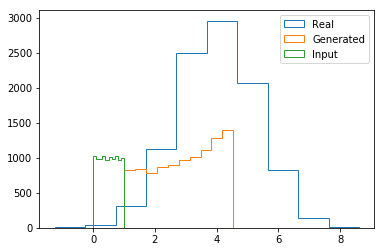

Stage 1 (Epoch: 200)
Mean and Std of Real: (3.9902269073543453, 1.233688886309252)
Mean and Std of Gen: (3.2929087, 1.6533941)


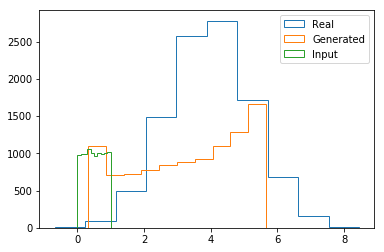

Stage 2 (Epoch: 400)
Mean and Std of Real: (4.008734017858289, 1.2328481795463577)
Mean and Std of Gen: (3.207076, 1.4932649)


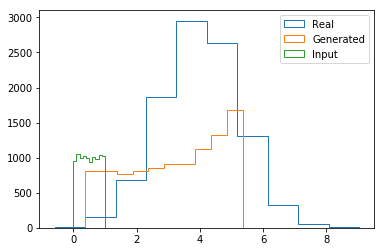

Stage 3 (Epoch: 600)
Mean and Std of Real: (3.999320955137958, 1.2401940875781063)
Mean and Std of Gen: (3.3682, 1.5303404)


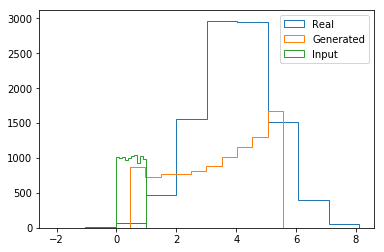

Stage 4 (Epoch: 800)
Mean and Std of Real: (4.013944328420107, 1.2470362997711635)
Mean and Std of Gen: (3.025521, 1.4895468)


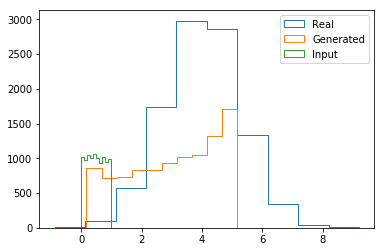

Stage 5 (Epoch: 1000)
Mean and Std of Real: (3.998490268652439, 1.2426074106743317)
Mean and Std of Gen: (3.5613987, 1.5413707)


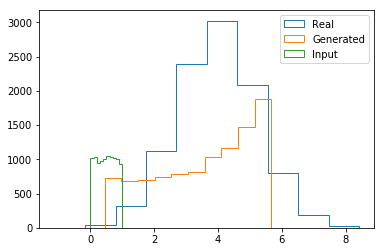

Stage 6 (Epoch: 1200)
Mean and Std of Real: (3.9881810018623813, 1.2503864745948743)
Mean and Std of Gen: (3.3403695, 1.3342198)


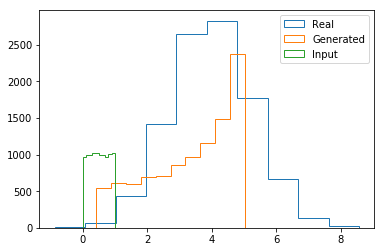

Stage 7 (Epoch: 1400)
Mean and Std of Real: (3.9957323053073313, 1.2480498876463189)
Mean and Std of Gen: (3.7285242, 1.3673756)


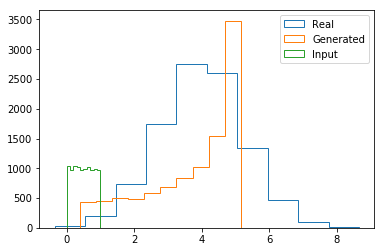

Stage 8 (Epoch: 1600)
Mean and Std of Real: (4.000818290586389, 1.2540200896377272)
Mean and Std of Gen: (4.187225, 1.2932137)


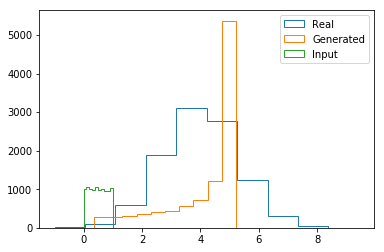

Stage 9 (Epoch: 1800)
Mean and Std of Real: (4.004391566506821, 1.2442668215618242)
Mean and Std of Gen: (4.760632, 1.1404594)


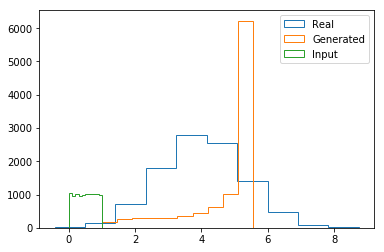

Stage 10 (Epoch: 2000)
Mean and Std of Real: (3.9889762415087158, 1.2481500481232368)
Mean and Std of Gen: (4.423878, 1.2060692)


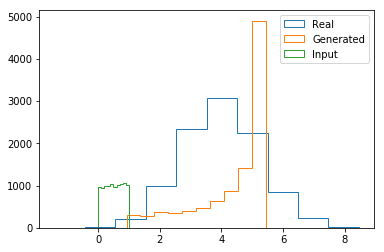

Stage 11 (Epoch: 2200)
Mean and Std of Real: (4.008186327193646, 1.2478944478200111)
Mean and Std of Gen: (4.167333, 1.3710889)


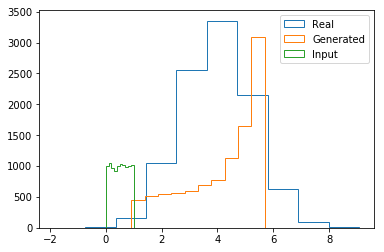

Stage 12 (Epoch: 2400)
Mean and Std of Real: (4.014458661059102, 1.257915774316821)
Mean and Std of Gen: (4.352284, 1.3287344)


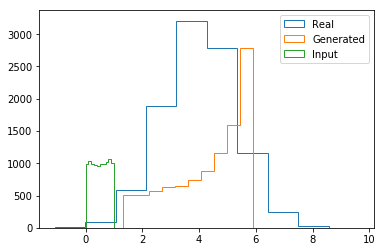

Stage 13 (Epoch: 2600)
Mean and Std of Real: (4.0115600393721875, 1.2414835095054224)
Mean and Std of Gen: (4.125427, 1.2468512)


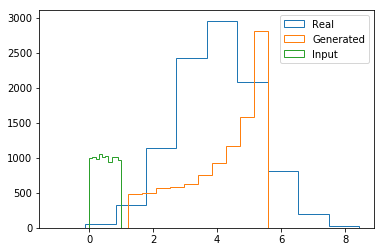

Stage 14 (Epoch: 2800)
Mean and Std of Real: (4.008599771284887, 1.2489408840755967)
Mean and Std of Gen: (4.215152, 1.2867213)


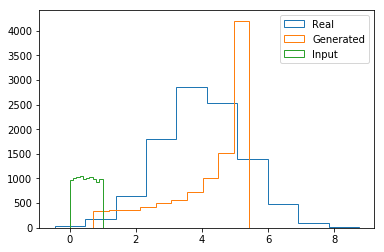

Stage 15 (Epoch: 3000)
Mean and Std of Real: (4.003460802724229, 1.235463298545982)
Mean and Std of Gen: (4.007161, 1.2423973)


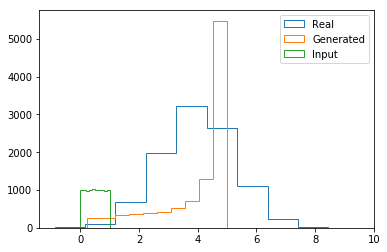

Stage 16 (Epoch: 3200)
Mean and Std of Real: (3.9927532404456323, 1.2259471204990218)
Mean and Std of Gen: (4.676534, 1.1881198)


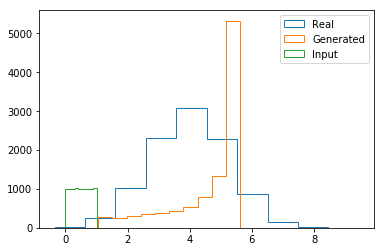

Stage 17 (Epoch: 3400)
Mean and Std of Real: (3.9953027963276466, 1.246576677080446)
Mean and Std of Gen: (4.0513725, 1.2209307)


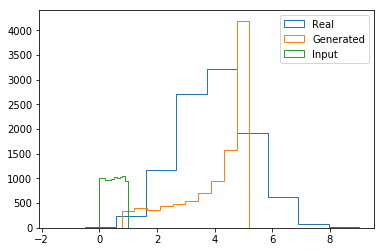

Stage 18 (Epoch: 3600)
Mean and Std of Real: (4.015507981942538, 1.254805711261142)
Mean and Std of Gen: (4.221089, 1.130131)


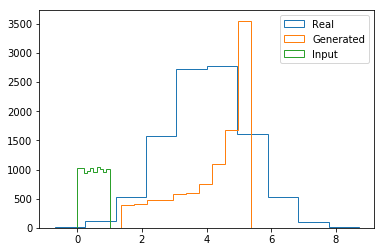

Stage 19 (Epoch: 3800)
Mean and Std of Real: (3.993255287118568, 1.2363424553502989)
Mean and Std of Gen: (4.351086, 1.1845597)


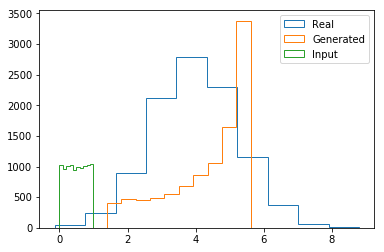

Stage 20 (Epoch: 4000)
Mean and Std of Real: (4.002672018341314, 1.257690427668797)
Mean and Std of Gen: (4.091874, 1.1820142)


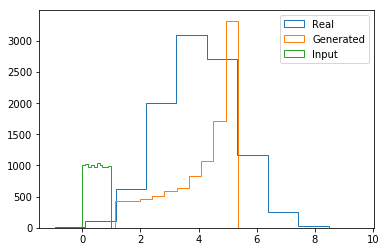

Stage 21 (Epoch: 4200)
Mean and Std of Real: (3.98097134120617, 1.2438479320846154)
Mean and Std of Gen: (3.6667542, 1.3718415)


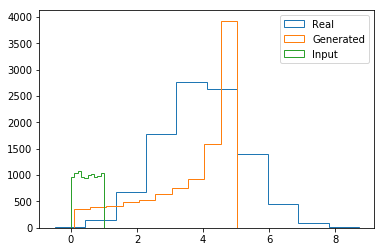

Stage 22 (Epoch: 4400)
Mean and Std of Real: (4.015070077351883, 1.2328117673104866)
Mean and Std of Gen: (4.20278, 1.1982476)


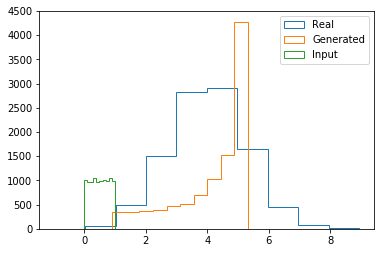

Stage 23 (Epoch: 4600)
Mean and Std of Real: (4.003322596034017, 1.2627479090920393)
Mean and Std of Gen: (3.8438542, 1.3146193)


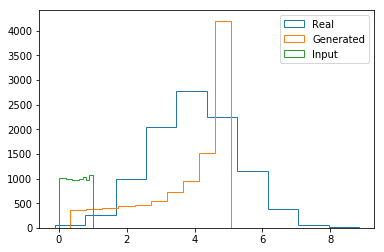

Stage 24 (Epoch: 4800)
Mean and Std of Real: (4.008797519081494, 1.24639497685553)
Mean and Std of Gen: (3.739682, 1.2231877)


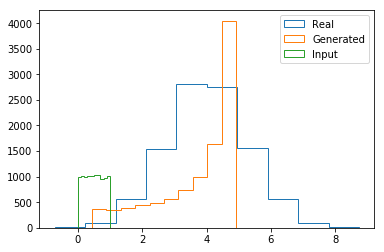

Stage 25 (Epoch: 5000)
Mean and Std of Real: (4.0094003563876965, 1.2505151844249194)
Mean and Std of Gen: (4.149437, 1.1899308)


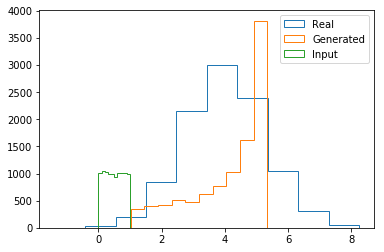

Stage 26 (Epoch: 5200)
Mean and Std of Real: (3.9946104996416865, 1.2643363397619434)
Mean and Std of Gen: (4.0597353, 1.3131495)


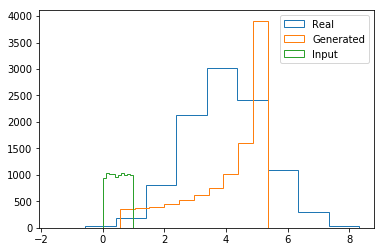

Stage 27 (Epoch: 5400)
Mean and Std of Real: (4.012478676587396, 1.2502373129537954)
Mean and Std of Gen: (3.8280325, 1.2893406)


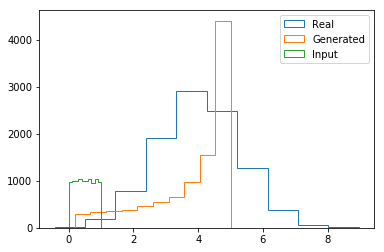

Stage 28 (Epoch: 5600)
Mean and Std of Real: (3.996798907978231, 1.260471214665764)
Mean and Std of Gen: (4.071506, 1.2288496)


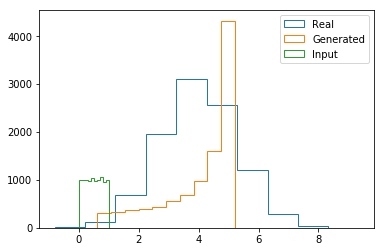

Stage 29 (Epoch: 5800)
Mean and Std of Real: (3.9848746566243802, 1.2364845329090595)
Mean and Std of Gen: (4.037596, 1.2485974)


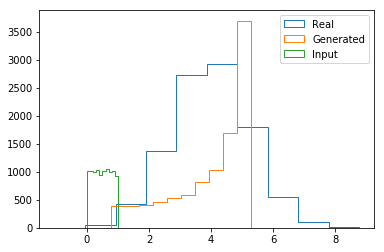

Stage 30 (Epoch: 6000)
Mean and Std of Real: (3.9942048168219886, 1.26853975592756)
Mean and Std of Gen: (4.4264975, 1.1923019)


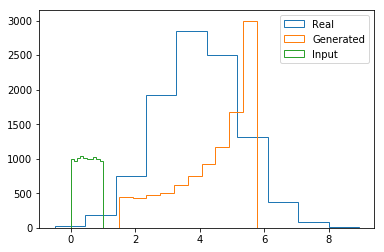

Stage 31 (Epoch: 6200)
Mean and Std of Real: (4.01064165127153, 1.2598247874126975)
Mean and Std of Gen: (4.027965, 1.275728)


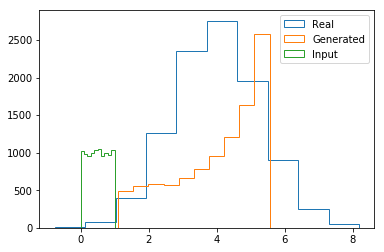

Stage 32 (Epoch: 6400)
Mean and Std of Real: (4.008516820640208, 1.2444470095783735)
Mean and Std of Gen: (3.699671, 1.2671212)


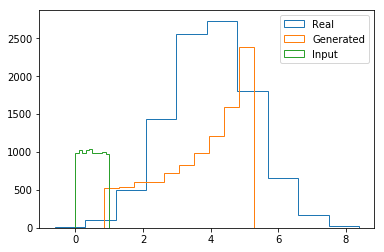

Stage 33 (Epoch: 6600)
Mean and Std of Real: (3.9993412594001065, 1.2572824898727977)
Mean and Std of Gen: (3.429524, 1.2261567)


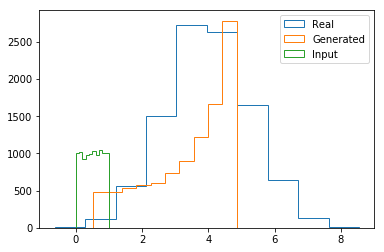

Stage 34 (Epoch: 6800)
Mean and Std of Real: (3.996871566202655, 1.2448326434981558)
Mean and Std of Gen: (4.076912, 1.2556655)


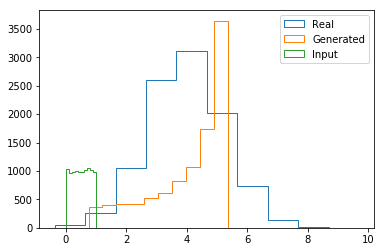

Stage 35 (Epoch: 7000)
Mean and Std of Real: (3.9936375367479164, 1.252189034194314)
Mean and Std of Gen: (4.183548, 1.3136426)


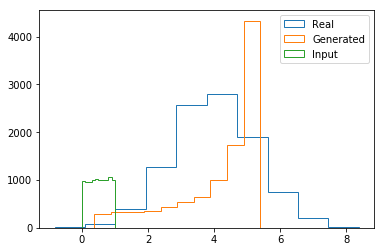

Stage 36 (Epoch: 7200)
Mean and Std of Real: (4.012084231330148, 1.2446687978301414)
Mean and Std of Gen: (4.031971, 1.3191)


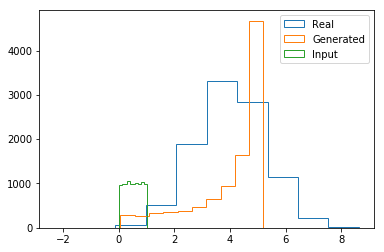

Stage 37 (Epoch: 7400)
Mean and Std of Real: (3.991121709297058, 1.2356704958247984)
Mean and Std of Gen: (3.919953, 1.1982347)


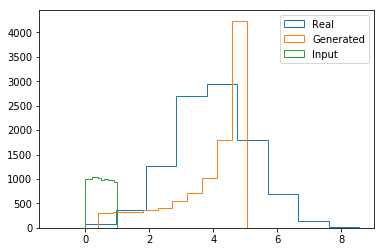

Stage 38 (Epoch: 7600)
Mean and Std of Real: (3.9996316505424367, 1.2405370046656157)
Mean and Std of Gen: (3.9855504, 1.3220358)


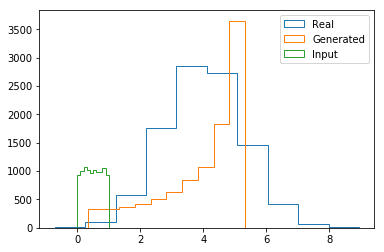

Stage 39 (Epoch: 7800)
Mean and Std of Real: (3.994567984455033, 1.2516310565683357)
Mean and Std of Gen: (4.25085, 1.2394578)


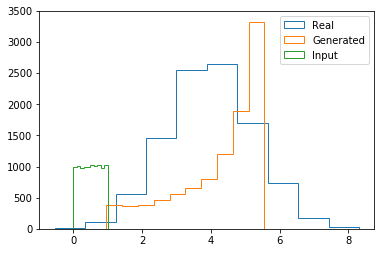

Stage 40 (Epoch: 8000)
Mean and Std of Real: (3.9838322955124363, 1.2435510187565841)
Mean and Std of Gen: (3.7950804, 1.21024)


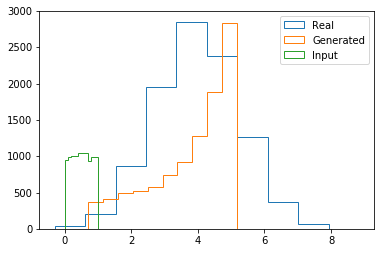

Stage 41 (Epoch: 8200)
Mean and Std of Real: (3.9830600320217826, 1.240666962562076)
Mean and Std of Gen: (3.835925, 1.2037619)


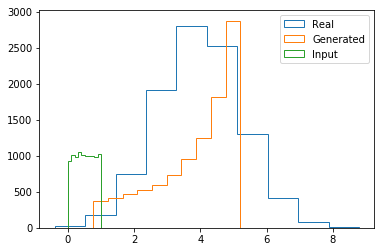

Stage 42 (Epoch: 8400)
Mean and Std of Real: (3.987519931546777, 1.2531125090203437)
Mean and Std of Gen: (3.8838813, 1.2050824)


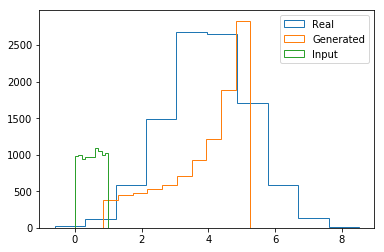

Stage 43 (Epoch: 8600)
Mean and Std of Real: (3.985189498636226, 1.2519219607097642)
Mean and Std of Gen: (3.9809895, 1.1679578)


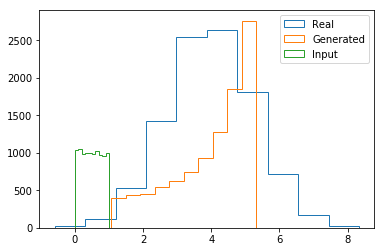

Stage 44 (Epoch: 8800)
Mean and Std of Real: (3.992907664863096, 1.2449923122741986)
Mean and Std of Gen: (3.8557644, 1.2069275)


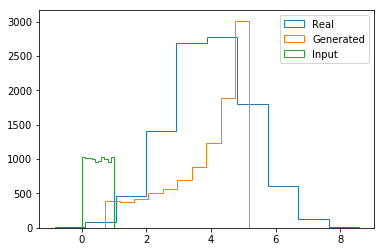

Stage 45 (Epoch: 9000)
Mean and Std of Real: (3.989975442298456, 1.2508581494290296)
Mean and Std of Gen: (4.130643, 1.2017076)


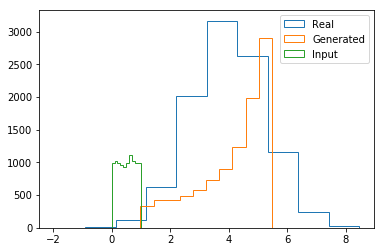

Stage 46 (Epoch: 9200)
Mean and Std of Real: (4.009019893021959, 1.2306034253497522)
Mean and Std of Gen: (4.106284, 1.2031658)


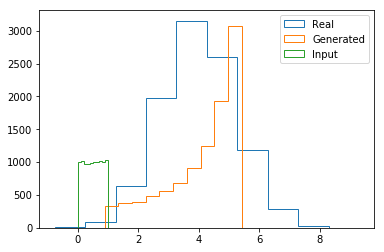

Stage 47 (Epoch: 9400)
Mean and Std of Real: (4.004806547979733, 1.2359552258942748)
Mean and Std of Gen: (3.9179327, 1.2539738)


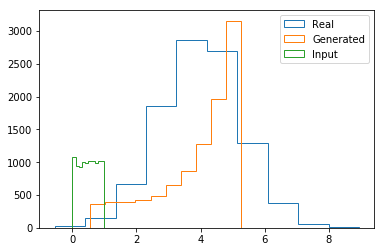

Stage 48 (Epoch: 9600)
Mean and Std of Real: (4.009758692382565, 1.2577671051462822)
Mean and Std of Gen: (3.7391133, 1.1982908)


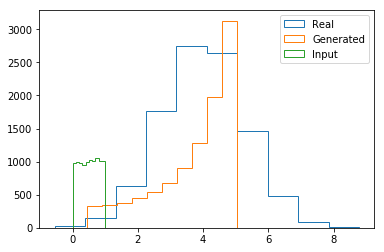

Stage 49 (Epoch: 9800)
Mean and Std of Real: (4.0322081725294625, 1.2397659010003965)
Mean and Std of Gen: (4.033894, 1.3386828)


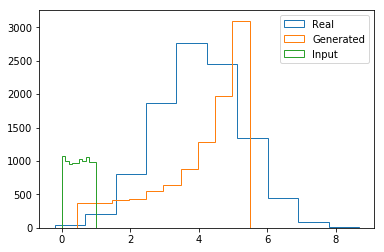

Stage 50 (Epoch: 10000)
Mean and Std of Real: (4.000526649618518, 1.2490046084670317)
Mean and Std of Gen: (4.1019454, 1.3389369)


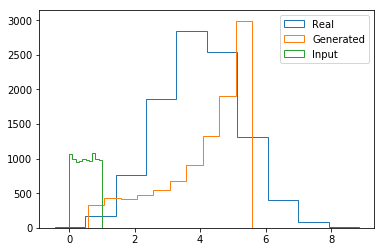

Stage 51 (Epoch: 10200)
Mean and Std of Real: (4.01409980098128, 1.2425734494947207)
Mean and Std of Gen: (4.1260505, 1.3099691)


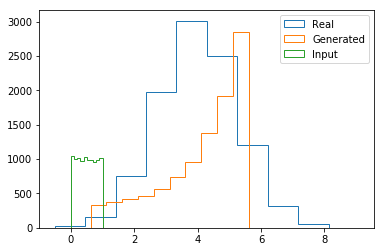

Stage 52 (Epoch: 10400)
Mean and Std of Real: (4.029117426993692, 1.2522669754639038)
Mean and Std of Gen: (4.410598, 1.3204935)


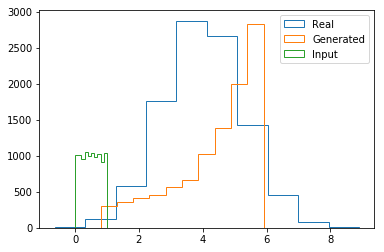

Stage 53 (Epoch: 10600)
Mean and Std of Real: (3.9699447189243537, 1.2414418023744553)
Mean and Std of Gen: (4.094837, 1.2486075)


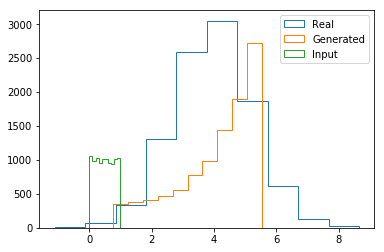

Stage 54 (Epoch: 10800)
Mean and Std of Real: (3.9929588212260243, 1.2389287898181052)
Mean and Std of Gen: (3.9890804, 1.2260526)


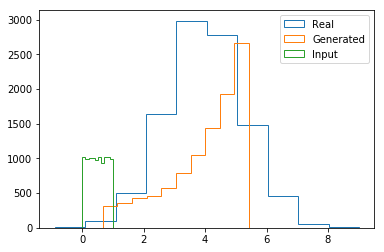

Stage 55 (Epoch: 11000)
Mean and Std of Real: (4.037842078242364, 1.2551926542419267)
Mean and Std of Gen: (3.9483328, 1.3199536)


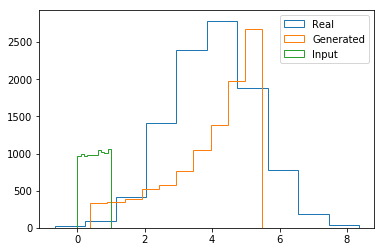

Stage 56 (Epoch: 11200)
Mean and Std of Real: (4.001312135195951, 1.2509698758331007)
Mean and Std of Gen: (4.061808, 1.1738122)


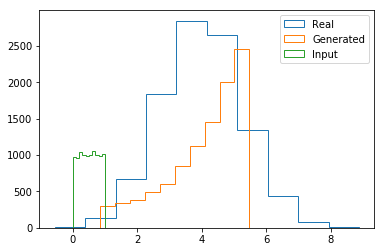

Stage 57 (Epoch: 11400)
Mean and Std of Real: (4.012689635074284, 1.2547550290761216)
Mean and Std of Gen: (4.164383, 1.4018451)


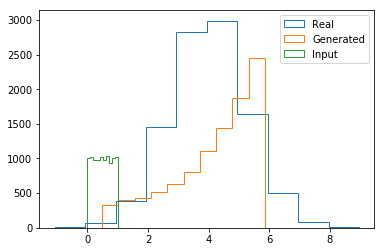

Stage 58 (Epoch: 11600)
Mean and Std of Real: (3.972824780961615, 1.2551452059051837)
Mean and Std of Gen: (3.6591492, 1.2681456)


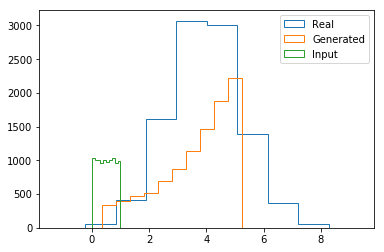

Stage 59 (Epoch: 11800)
Mean and Std of Real: (3.987745225778978, 1.2618307874701884)
Mean and Std of Gen: (3.819075, 1.3158908)


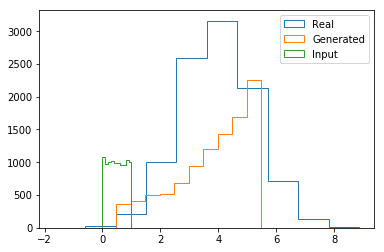

Stage 60 (Epoch: 12000)
Mean and Std of Real: (3.9921269653312432, 1.2562522100991416)
Mean and Std of Gen: (3.8863184, 1.2362341)


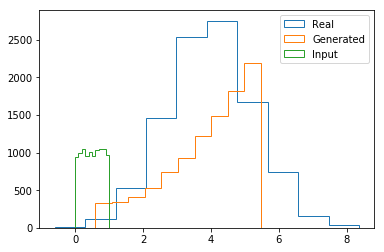

Stage 61 (Epoch: 12200)
Mean and Std of Real: (4.014380107156265, 1.2392958202435445)
Mean and Std of Gen: (3.5358875, 1.1505337)


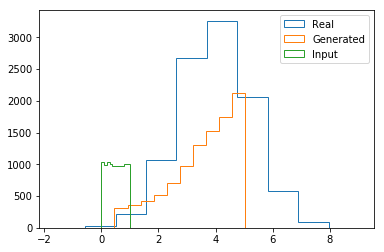

Stage 62 (Epoch: 12400)
Mean and Std of Real: (3.9961301418975186, 1.254576511804388)
Mean and Std of Gen: (3.7827437, 1.2547181)


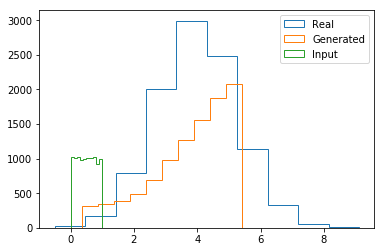

Stage 63 (Epoch: 12600)
Mean and Std of Real: (4.003736559040038, 1.2687504972023198)
Mean and Std of Gen: (4.0905166, 1.3222305)


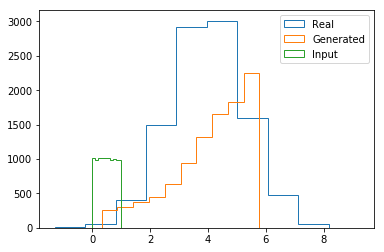

Stage 64 (Epoch: 12800)
Mean and Std of Real: (3.9748516733800288, 1.2543954689322898)
Mean and Std of Gen: (4.0164313, 1.2370248)


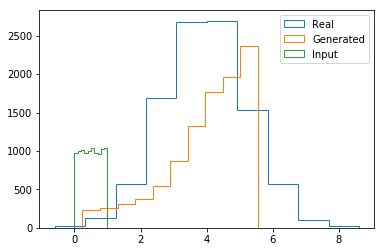

Stage 65 (Epoch: 13000)


In [ ]:
main()